Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("SkinCancerImaging\Train")
data_dir_test = pathlib.Path('SkinCancerImaging\Test')

In [5]:
from glob import glob
import shutil
for outDir in glob(os.path.join(data_dir_train, '*')):
    if os.path.isdir(os.path.join(outDir, 'output')):
        shutil.rmtree(os.path.join(outDir, 'output'))

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180
img_size = (img_height, img_width)
seed = 123

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            validation_split=0.2,
            subset="training",
            seed=seed,
            image_size=img_size,
            batch_size=batch_size)
train_ds

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
          data_dir_train,
          validation_split=0.2,
          subset="validation",
          seed=seed,
          image_size=img_size,
          batch_size=batch_size)
val_ds

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

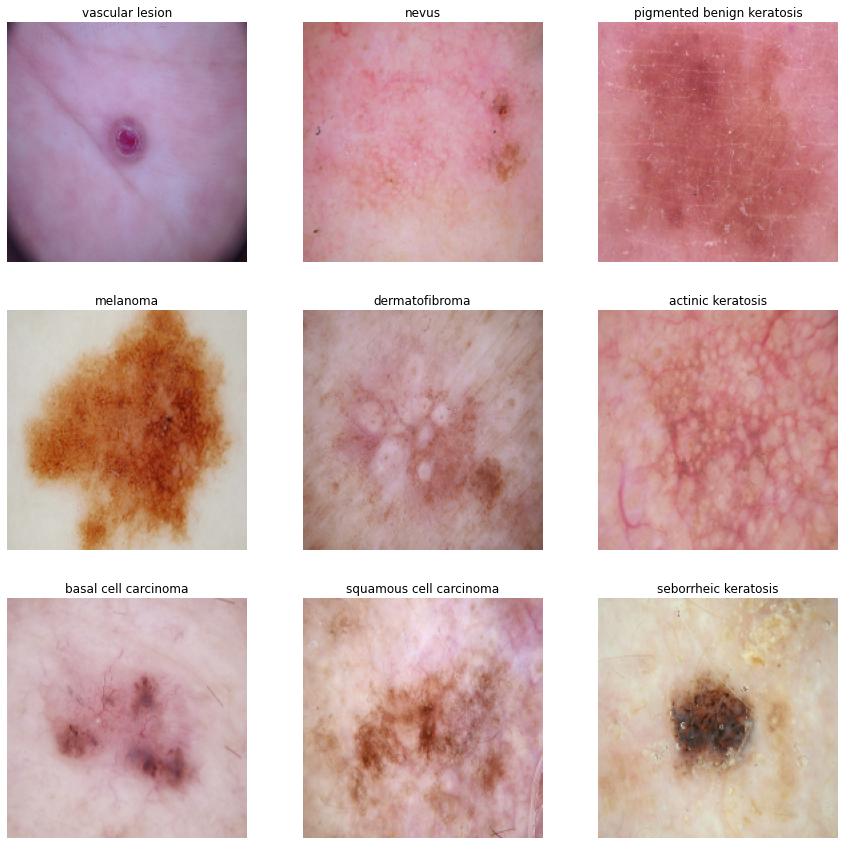

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
printedImgCls = []
for img_list, lbl_list in train_ds:
    for i in range(len(lbl_list)):
        if len(printedImgCls) == len(class_names):
            break
        if class_names[lbl_list[i]] not in printedImgCls:
            ax = plt.subplot(3, 3, len(printedImgCls)+1)
            plt.imshow(img_list[i].numpy().astype('uint8'))
            plt.title(class_names[lbl_list[i]])
            plt.axis('off')
            printedImgCls.append(class_names[lbl_list[i]])
            if len(printedImgCls) == len(class_names):
                break
    if len(printedImgCls) == len(class_names):
        break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
model = Sequential()
# Preprocessing layer for rescaling
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)))

# Convolution and MaxPool layer
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Flatten & softmax layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(len(class_names), activation="softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        36928     
                                                      

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 84s 1s/step - loss: 2.1028 - accuracy: 0.1953 - val_loss: 2.0371 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 81s 1s/step - loss: 2.0354 - accuracy: 0.2031 - val_loss: 2.0146 - val_accuracy: 0.2662
Epoch 3/20
56/56 [==============================] - 85s 2s/step - loss: 1.8737 - accuracy: 0.3064 - val_loss: 1.7054 - val_accuracy: 0.3915
Epoch 4/20
56/56 [==============================] - 85s 2s/step - loss: 1.7071 - accuracy: 0.3705 - val_loss: 1.5437 - val_accuracy: 0.4519
Epoch 5/20
56/56 [==============================] - 81s 1s/step - loss: 1.5434 - accuracy: 0.4531 - val_loss: 1.5990 - val_accuracy: 0.4474
Epoch 6/20
56/56 [==============================] - 65s 1s/step - loss: 1.5106 - accuracy: 0.4833 - val_loss: 1.4555 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 65s 1s/step - loss: 1.3601 - accuracy: 0.5067 - val_loss: 1.5522 - val_accuracy: 0.4653
Epoch 8/20
56/56 [==

### Visualizing training results

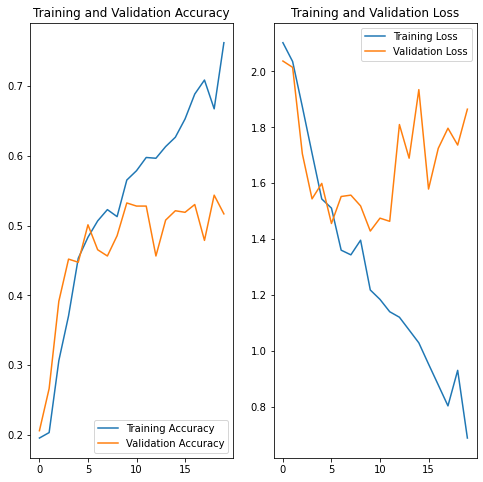

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings:
##### - Model is overfitting though training accuracy is also not good.
##### - Increasing epoch might increase training accuracy but I believe that it will further overfit. 

### Building the model again with BN and Dropout.

In [20]:
model = Sequential()
# Preprocessing layer for rescaling
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)))

# Convolution and MaxPool layer
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

# Flatten & softmax layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(len(class_names), activation="softmax"))



# Compile the Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# View the summary of all layers of Model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)      

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 115s 2s/step - loss: 13.9839 - accuracy: 0.2271 - val_loss: 5.6338 - val_accuracy: 0.0537
Epoch 2/20
56/56 [==============================] - 94s 2s/step - loss: 1.9572 - accuracy: 0.3041 - val_loss: 44.7319 - val_accuracy: 0.0537
Epoch 3/20
56/56 [==============================] - 91s 2s/step - loss: 1.8568 - accuracy: 0.3577 - val_loss: 61.8260 - val_accuracy: 0.0626
Epoch 4/20
56/56 [==============================] - 91s 2s/step - loss: 1.7519 - accuracy: 0.3744 - val_loss: 59.0285 - val_accuracy: 0.0425
Epoch 5/20
56/56 [==============================] - 91s 2s/step - loss: 1.6822 - accuracy: 0.3956 - val_loss: 50.7694 - val_accuracy: 0.0537
Epoch 6/20
56/56 [==============================] - 91s 2s/step - loss: 1.6449 - accuracy: 0.3923 - val_loss: 33.0695 - val_accuracy: 0.0537
Epoch 7/20
56/56 [==============================] - 91s 2s/step - loss: 1.6196 - accuracy: 0.3990 - val_loss: 22.3432 - val_accuracy: 0.0626
Epoch 8/20
5

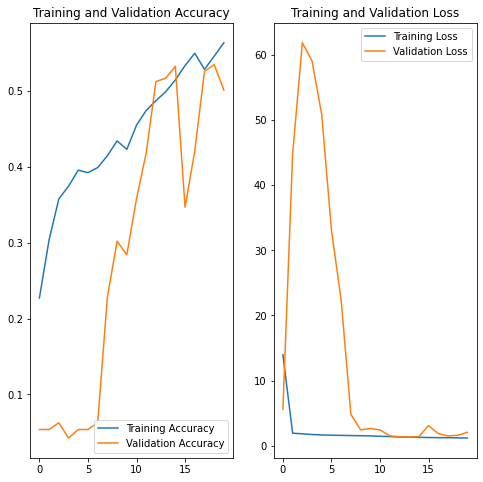

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings:
##### - Model is underfitting as training accurancy is not great and validation loss is also closely following training loss.
#### Assumption:
##### - Increasing epoch might increase training and validation accuracy.

#### Training this model further for 10 more epochs to test the assumption.

In [23]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
56/56 [==============================] - 98s 2s/step - loss: 1.2537 - accuracy: 0.5430 - val_loss: 4.6862 - val_accuracy: 0.2864
Epoch 2/10
56/56 [==============================] - 99s 2s/step - loss: 1.2533 - accuracy: 0.5441 - val_loss: 2.0150 - val_accuracy: 0.4743
Epoch 3/10
56/56 [==============================] - 92s 2s/step - loss: 1.1978 - accuracy: 0.5686 - val_loss: 2.3130 - val_accuracy: 0.4295
Epoch 4/10
56/56 [==============================] - 91s 2s/step - loss: 1.2104 - accuracy: 0.5720 - val_loss: 2.3607 - val_accuracy: 0.4832
Epoch 5/10
56/56 [==============================] - 91s 2s/step - loss: 1.1876 - accuracy: 0.5770 - val_loss: 1.5980 - val_accuracy: 0.5347
Epoch 6/10
56/56 [==============================] - 92s 2s/step - loss: 1.0905 - accuracy: 0.5949 - val_loss: 1.6128 - val_accuracy: 0.5369
Epoch 7/10
56/56 [==============================] - 94s 2s/step - loss: 1.0715 - accuracy: 0.6071 - val_loss: 1.8409 - val_accuracy: 0.5347
Epoch 8/10
56/56 [==

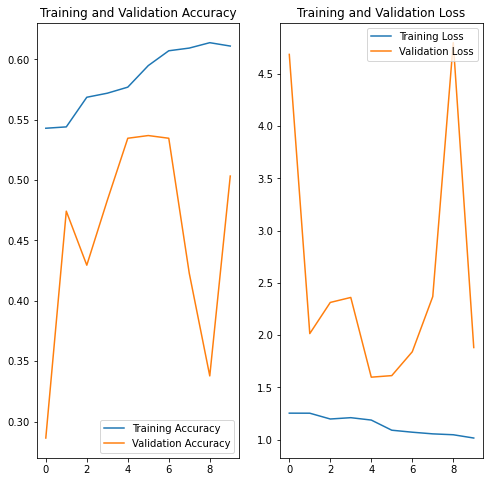

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings:
##### - In contrary to our assumption, model has started overfitting from start.
##### - Increasing epoch led to increased training accuracy but also increased validation loss.

#### Thus with 30 epochs, model is started overfitting. Somewhere at around 19 epochs, model was giving best result
#### but acccuracy was still around 50%

### Check Class Imbalance

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
inputData = dict()
for dataDir in data_dir_train.glob('*'):
    inputData[os.path.basename(dataDir)] = len(list(dataDir.glob('*.jpg')))
{key : inputData[key] for key in sorted(inputData, key=lambda k: inputData[k])}

{'seborrheic keratosis': 77,
 'dermatofibroma': 95,
 'actinic keratosis': 114,
 'vascular lesion': 139,
 'squamous cell carcinoma': 181,
 'nevus': 357,
 'basal cell carcinoma': 376,
 'melanoma': 438,
 'pigmented benign keratosis': 462}

#### - Which class has the least number of samples? : "seborrheic keratosis"
#### - Which classes dominate the data in terms proportionate number of samples? "pigmented benign keratosis"


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
import Augmentor
for i in class_names:
    data_dir_train_per_class = os.path.join(data_dir_train, i)
    if os.path.isdir(os.path.join(data_dir_train_per_class, 'output')):
        shutil.rmtree(os.path.join(data_dir_train_per_class, 'output'))
    p = Augmentor.Pipeline(data_dir_train_per_class)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to SkinCancerImaging\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x289B10B1CD0>: 100%|█| 500/500 [00:02<00:00, 234.51 Samples


Initialised with 376 image(s) found.
Output directory set to SkinCancerImaging\Train\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x289BB109820>: 100%|█| 500/500 [00:02<00:


Initialised with 95 image(s) found.
Output directory set to SkinCancerImaging\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x289BA2EF580>: 100%|█| 500/500 [00:02<00:00, 237.63 Samples


Initialised with 438 image(s) found.
Output directory set to SkinCancerImaging\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x289CE2E90A0>: 100%|█| 500/500 [00:11<00:00, 45.35 Samples


Initialised with 357 image(s) found.
Output directory set to SkinCancerImaging\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=576x768 at 0x289B0ABB6A0>: 100%|█| 500/500 [00:11<00:00, 44.09 Samples/


Initialised with 462 image(s) found.
Output directory set to SkinCancerImaging\Train\pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x289B0990AC0>: 100%|█| 500/500 [00:02<00:


Initialised with 77 image(s) found.
Output directory set to SkinCancerImaging\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x289BB52A160>: 100%|█| 500/500 [00:04<00:00, 106.40 Sample


Initialised with 181 image(s) found.
Output directory set to SkinCancerImaging\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x289CE26FAC0>: 100%|█| 500/500 [00:02<00:00, 236.82 Samples


Initialised with 139 image(s) found.
Output directory set to SkinCancerImaging\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x289BB48A4C0>: 100%|█| 500/500 [00:02<00:00, 234.66 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list   = [ x for x in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
lesion_list = [ os.path.basename(os.path.dirname(y)) for y in path_list ]
print("path_list   : ", len(path_list))
print("lesion_list : ", len(lesion_list))
path_list_new   = [ x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [ os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list_new]

path_list.extend(path_list_new)
lesion_list.extend(lesion_list_new)

print("path_list   : ", len(path_list))
print("lesion_list : ", len(lesion_list))

path_list   :  2239
lesion_list :  2239
path_list   :  6739
lesion_list :  6739


In [31]:
from collections import Counter
Counter(lesion_list)

Counter({'actinic keratosis': 614,
         'basal cell carcinoma': 876,
         'dermatofibroma': 595,
         'melanoma': 938,
         'nevus': 857,
         'pigmented benign keratosis': 962,
         'seborrheic keratosis': 577,
         'squamous cell carcinoma': 681,
         'vascular lesion': 639})

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

#### **Todo:** Create a training dataset

In [32]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            validation_split=0.2,
            subset="training",
            seed=seed,
            image_size=img_size,
            batch_size=batch_size)
train_ds

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### **Todo:** Create a validation dataset

In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
          data_dir_train,
          validation_split=0.2,
          subset="validation",
          seed=seed,
          image_size=img_size,
          batch_size=batch_size)
val_ds

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### **Todo:** Create your model (make sure to include normalization)

In [34]:
model = Sequential()
# Preprocessing layer for rescaling
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)))

# Convolution and MaxPool layer
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

# Flatten & softmax layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(len(class_names), activation="softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [35]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_7 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)      

#### **Todo:**  Train your model

In [36]:
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
169/169 [==============================] - 293s 2s/step - loss: 7.8799 - accuracy: 0.2066 - val_loss: 49.1460 - val_accuracy: 0.1336
Epoch 2/40
169/169 [==============================] - 294s 2s/step - loss: 1.9785 - accuracy: 0.2443 - val_loss: 25.6155 - val_accuracy: 0.1470
Epoch 3/40
169/169 [==============================] - 298s 2s/step - loss: 1.9283 - accuracy: 0.2524 - val_loss: 6.3542 - val_accuracy: 0.1811
Epoch 4/40
169/169 [==============================] - 297s 2s/step - loss: 1.9205 - accuracy: 0.2574 - val_loss: 3.3995 - val_accuracy: 0.2160
Epoch 5/40
169/169 [==============================] - 299s 2s/step - loss: 1.8639 - accuracy: 0.2665 - val_loss: 1.9991 - val_accuracy: 0.3140
Epoch 6/40
169/169 [==============================] - 296s 2s/step - loss: 1.8156 - accuracy: 0.3097 - val_loss: 1.7762 - val_accuracy: 0.3445
Epoch 7/40
169/169 [==============================] - 303s 2s/step - loss: 1.7739 - accuracy: 0.3195 - val_loss: 3.1051 - val_accuracy: 0.25

#### **Todo:**  Visualize the model results

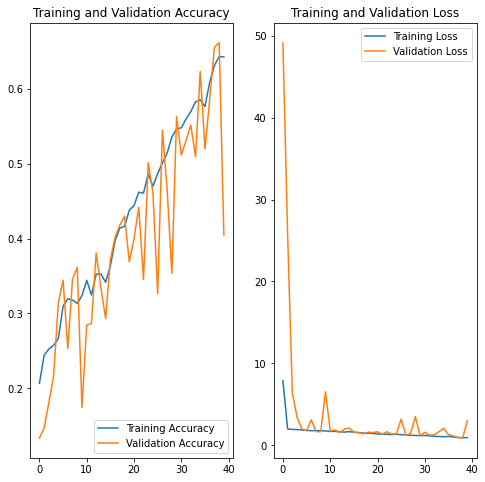

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



#### Yes, class rebalance helped it. Now Validation accuracy is trying to follow the training accuracy more closely.
#### Given more time and compute resources, one can play with "SeparableConv2D" along with "Conv2D"